In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import LayerNormalization
import os
import seaborn as sns
from keras.applications.vgg19 import VGG19

In [1]:
import cv2
import sys
import os
import csv
import dlib
import scipy
from scipy import ndimage
from skimage import measure, io, img_as_ubyte
import matplotlib.pyplot as plt
from skimage.color import label2rgb, rgb2gray
import numpy as np
import glob
import pandas as pd
from sklearn.cluster import KMeans #for clusterin
from os import listdir
from os.path import isfile, join

In [3]:
##Feature extraction 


import numpy as np  
import cv2  
import dlib  
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import os
import imutils
import math

def get_norm(image,x1,y1,x2,y2):
    x = (int(image[x1][y1][0])-int(image[x2][y2][0]))**2
    y = (int(image[x1][y1][1])-int(image[x2][y2][1]))**2
    z = (int(image[x1][y1][2])-int(image[x2][y2][2]))**2
    norm = x + y + z
    return norm

def get_min(image,x1,y1):
    x = int(image[x1][y1][0])
    y = int(image[x1][y1][1])
    z = int(image[x1][y1][2])
    return np.min([x,y,z])

def get_color(image,x,y,gray):
    if gray == 1: image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.min(image[y,x])
    
def get_lum(image,x,y,w,h,k,gray):
    if gray == 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    i1 = range(int(-w/2),int(w/2))
    j1 = range(0,h)
    lumar = np.zeros((len(i1),len(j1)))
    for i in i1:
        for j in j1:
            lum = np.min(image[y+k*h,x+i])
            lumar[i][j] = lum
    
    return np.min(lumar)

def get_ave_down(image,x,y,h,w):
    ave = np.min(image[x-w:x+w,y-h:y])
    return int(ave)
def get_ave_up(image,x,y,h,w):
    ave = np.max(image[x-w:x+w,y:y+h])
    return int(ave)

def d(landmarks,index1,index2):
#get distance between i1 and i2
    x1 = landmarks[int(index1)][0]
    y1 = landmarks[int(index1)][1]
    x2 = landmarks[int(index2)][0]
    y2 = landmarks[int(index2)][1]
    x_diff = (x1 - x2)**2
    y_diff = (y1 - y2)**2
    dist = math.sqrt(x_diff + y_diff)
    return dist

def q(landmarks,index1,index2):
#get angle between a i1 and i2
    x1 = landmarks[int(index1)][0]
    y1 = landmarks[int(index1)][1]
    x2 = landmarks[int(index2)][0]
    y2 = landmarks[int(index2)][1]
    
    x_diff = float(x1 - x2)
    if (y1 == y2): y_diff = 0.1
    if (y1 < y2): y_diff = float(np.absolute(y1 - y2))
    if (y1 > y2):
        y_diff = 0.1
    
        print("Error: Facial feature located below chin.")
    
    return np.absolute(math.atan(x_diff/y_diff))

In [323]:
##features
b=[]
def features(image, detector):
    faces = detector.detect_faces(image)
    #print(faces)
    #global data    
    
#     faces = faceCascade.detectMultiScale(image, 
#                                          scaleFactor = 1.1, #1.1 
#                                          minNeighbors = 5, 
#                                          minSize = (30, 30), 
#                                          flags = cv2.CASCADE_SCALE_IMAGE  ) 
    print("Found {0} faces!".format(len(faces)))  
   # if len(faces)==1:
        
    for result in faces:
        x, y, w, h = result['box']
        y=int(0.95*y)
        h=int(1.05*h)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), 2)
        dlib_rect = dlib.rectangle(int(x), int(0.95*y), int(x + w), int(y + 1.05*h))
        detected_landmarks = predictor(image, dlib_rect).parts()
        landmarks = np.matrix([[p.x, p.y] for p in detected_landmarks]) 
        image_copy = image.copy() 
       
        print(image_copy)
        for idx, point in enumerate(landmarks): 
            pos = (point[0, 0], point[0, 1])
            cv2.circle(image_copy, pos, 3, color=(255, 153, 0))
            p27 = (landmarks[27][0,0],landmarks[27][0,1])
            x = p27[0]
            y1 = p27[1]
            gray = 0
            diff = get_lum(image,x,y1,8,1,-1,gray)
                #print(diff)
            limit = diff-5
                
            while (diff > limit):
                    y1 = int(y1 - 1)
                    diff = get_lum(image,x,y1,6,1,-1,gray)
            cv2.circle(image_copy, (x,y1), 3, color=(255, 153, 0))
            plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
            cv2.imwrite("agreene.jpg", image_copy)
                #plt.show()
            cv2.waitKey(0)
            lmark = landmarks.tolist()
            p68 = ((x,y1))
            lmark.append(p68)
            
            
            g=[]
            h=[]
            
            ##left eye
            p1=d(lmark, 38,42)
            p2=d(lmark, 37,40)
            r1=(p2/p1)
            ##right eye
            p3=d(lmark, 43,46)
            p4=d(lmark, 44,48)
            r2=(p3/p4)
            
            ## Nose ratio
            p5=d(lmark,31,34)
            p6=d(lmark, 32,36)
            r3=(p6/p5)
            
            
                
            fwidth = d(lmark,0,16)
            fheight = d(lmark,8,68)
            c=(fheight/fwidth)
            jwidth = d(lmark,4,12)
            j=(jwidth/fwidth)
               
            hchinmouth = d(lmark,57,8)
            e=(hchinmouth/fwidth)
            ref = q(lmark,27,8)
            f=ref
            for k in range(0,17):
              if k != 8:
               theta = q(lmark,k,8)
               g.append(theta)
            x=np.array(g)
            for k in range(1,8):
              dist = d(lmark,k,16-k)
              h.append(dist/fwidth)
            y=np.array(h)
            z=np.concatenate([x,y])
            #k=[label_2,c,j,e,f]
            
            #feature=np.concatenate([k,z])
        
                
        feature=[r1,r2,r3,diff,fwidth, fheight,c,jwidth,j,hchinmouth,e,ref]   # dfmaster = pd.concat( df_t,   data)
        data_1=np.concatenate([feature,z])
        data=data_1.tolist()
        
     # else:
      #   data='no face'
        #print(data)
    return  data

In [324]:

##train_data ='E:/projects/Face shape classification/spyder/data/crop img - Testing/*'
faceCascade =  cv2.CascadeClassifier('E:/projects/Face shape classification/spyder/haarcascade_frontalface_default.xml')
predictor_path= 'E:/projects/Face shape classification/spyder/shape_predictor_68_face_landmarks.dat'
  
predictor = dlib.shape_predictor(predictor_path) 

In [325]:
SIZE =256 #Resize images

In [326]:

    pyplot.show()


E:/projects/Face shape classification/spyder/data/algo test data/
E:/projects/Face shape classification/spyder/data/algo test data\So-Eum (1).jpg
Found 1 faces!
[[[136 142 140]
  [135 141 139]
  [138 144 142]
  ...
  [147 153 151]
  [146 152 150]
  [146 152 150]]

 [[136 142 140]
  [137 143 141]
  [138 144 142]
  ...
  [148 154 152]
  [146 152 150]
  [146 152 150]]

 [[136 142 140]
  [139 145 143]
  [138 144 142]
  ...
  [149 155 153]
  [146 152 150]
  [146 152 150]]

 ...

 [[136 142 140]
  [136 142 140]
  [136 142 140]
  ...
  [146 152 150]
  [145 151 149]
  [145 151 149]]

 [[135 141 139]
  [135 141 139]
  [135 141 139]
  ...
  [146 152 150]
  [145 151 149]
  [145 151 149]]

 [[134 140 138]
  [134 140 138]
  [134 140 138]
  ...
  [146 152 150]
  [145 151 149]
  [145 151 149]]]
E:/projects/Face shape classification/spyder/data/algo test data\So-Eum (2).jpg
Found 1 faces!
[[[12 14 26]
  [12 14 26]
  [12 14 26]
  ...
  [10 12 24]
  [10 12 24]
  [11 13 25]]

 [[12 14 26]
  [12 14 26]
  

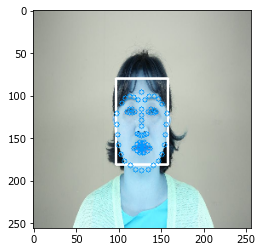

In [330]:

# face detection with mtcnn on a photograph
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
detector = MTCNN()

faces = detector.detect_faces(image)



In [331]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_features_1=np.array(train_features_1)
train_features_1.shape


(4, 35)

In [332]:
test_images = []
test_labels = [] 
test_features_1 = [] 
for directory_path in glob.glob("E:/projects/Face shape classification/spyder/data/crop img - Testing/Test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (SIZE, SIZE))
        image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        test_features=features(image,faceCascade )
        test_images.append(image)
        test_labels.append(fruit_label)
        test_features_1.append(test_features)
test_features=np.array(test_features_1)

AttributeError: 'cv2.CascadeClassifier' object has no attribute 'detect_faces'

In [ ]:
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_features_1=np.array(test_features)

test_features.shape

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
print(train_labels_encoded )
print(train_labels)


#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0


#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF


In [ ]:
feature_extractor=VGG_model.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

X_for_training.shape


In [ ]:
feature_train=np.concatenate([train_features_1,X_for_training],axis=1)
feature_train.shape

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(feature_train)
feature_train = imputer.transform(feature_train)
print(feature_train.shape)

In [ ]:
X_test_feature =VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)


In [ ]:
feature_test=np.concatenate([test_features_1,X_test_features],axis=1)
feature_test.shape

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(feature_test)
feature_test = imputer.transform(feature_test)
X_test=feature_test
X_train=feature_train
Y_train=y_train
Y_test=y_test
print(X_test.shape)

# XGBOOST

In [ ]:
#XGBOOST
import xgboost as xgb
XGB = xgb.XGBClassifier()
XGB.fit(X_train, Y_train) #For sklearn no one hot encoding
#Now predict using the trained RF model. 
prediction = XGB.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(classification_report(y_test, prediction))
print(accuracy_score(Y_test, prediction))
cm=confusion_matrix(Y_test, prediction)
print(Y_test)

Found 1 faces!
[[[216 211 210]
  [216 210 210]
  [216 211 210]
  ...
  [214 209 208]
  [213 208 207]
  [215 210 209]]

 [[215 210 209]
  [217 212 211]
  [216 211 210]
  ...
  [214 209 208]
  [216 211 210]
  [214 209 208]]

 [[216 211 210]
  [216 211 210]
  [218 213 212]
  ...
  [214 209 208]
  [214 209 208]
  [214 209 208]]

 ...

 [[ 59  62  46]
  [ 72  75  59]
  [ 69  72  56]
  ...
  [ 73  76  61]
  [ 78  81  66]
  [ 78  82  66]]

 [[ 70  70  56]
  [ 69  71  57]
  [ 79  82  67]
  ...
  [ 75  78  63]
  [ 82  85  70]
  [ 81  84  69]]

 [[ 78  78  67]
  [ 72  74  58]
  [ 81  84  68]
  ...
  [ 77  80  65]
  [ 74  77  62]
  [ 75  79  62]]]
[0.24563835487063315, 0.15245603039863292, 2.544178344864847, 118.0, 150.6154042586614, 115.62439189029277, 0.7676797234612447, 119.26860441876563, 0.7918752069604917, 23.08679276123039, 0.1532830780149285, 0.1057981729237937, 0.6308613325249379, 0.7051113481144319, 0.8055296715278508, 0.9137213910832431, 1.0106749426115036, 1.089909046599561, 1.1737168

NameError: name 'VGG_model' is not defined

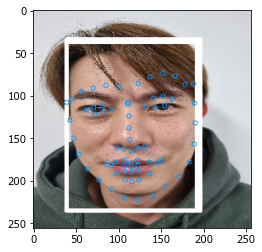

In [141]:
##Test the model
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
from keras.preprocessing import image
test_features_1 = [] 
SIZE=256
#x_test.shape
#x_test.dtype    
image=cv2.imread('C:/Users/2109902/Desktop/img21.jpg')
#image=cv2.imread('E:/projects/Face shape classification/spyder/new_data/project/안면인식 체질진단 샘플사진/소음/소음인_남자/2-소음.jpg')
image = cv2.resize(image, (SIZE, SIZE))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
features_2=features(img, detector)
print(features_2)
test_features_1.append(features_2)
features_1=np.array(test_features_1)
input_img = np.expand_dims(image, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
X_test_features_1 = input_img_feature.reshape(input_img_feature.shape[0], -1)
predict_feature=np.concatenate([features_1,X_test_features_1],axis=1)

input_img_features=predict_feature.reshape(predict_feature.shape[0], -1)
prediction_1 = model.predict_proba(input_img_features)[0]
prediction_2 = model.predict(input_img_features)[0]
prediction_2 = le.inverse_transform([prediction_2])  #Reverse the label encoder to original name

print("The prediction for this image is: ", prediction_2)
print("The prediction for this image is: ", prediction_1)
print(prediction_1.dtype)
print("The actual label for this image is: ", test_labels[n])
plt.imshow(img)

{'So_Eum': 10.0, 'So_Yang': 50.0, 'Ta_Eum': 40.0}


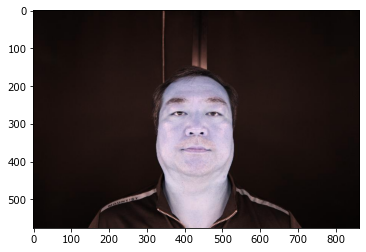

In [320]:

import base64
import json
import cv2
import requests
import matplotlib.pyplot as plt
api = 'http://203.241.246.174:55000/Face_shape'
#api = 'http://192.168.60.129:8887/Face_shape'
image_file = 'E:/projects/Face shape classification/spyder/data/D_IMP/So-yang/So-yang (84).jpg'

with open(image_file, "rb") as f:
    im_bytes = f.read()
im_b64 = base64.b64encode(im_bytes).decode("utf8")

headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

payload = json.dumps({"image": im_b64})
response = requests.post(api, data=payload, headers=headers)
image=cv2.imread(image_file)
try:
    data = response.json()
    print(data)
    plt.imshow(image)
except requests.exceptions.RequestException:
    print(response.text)

## 